# Boundary layer in transition to turbulence


Jared Callaham (2020)

Here we study the Reynolds-averaged Navier-Stokes (RANS) equations.  Fields are obtained by averages of the DNS by Lee & Zaki available from the [Johns Hopkins turbulence database](http://turbulence.pha.jhu.edu/Transition_bl.aspx).
Average profiles can be downloaded [here](http://turbulence.pha.jhu.edu/docs/transition_bl/Transition_BL_Time_Averaged_Profiles.h5).
As for the cylinder wake, we focus on the streamwise component of the equations:
$$ \bar{u} \bar{u}_x + \bar{v} \bar{u}_y = \rho^{-1} \bar{p}_x + \nu \nabla^2 \bar{u}  - (\overline{u' v'})_y - (\overline{u'^2})_x $$
The main dominant balance physics we expect to see are in the inertial and viscous sublayers in the turbulent region, where the wall-normal Reynolds stress $(\overline{u' v'})_y$ is balanced by mean flow advection and viscosity, respectively.

In [1]:
import numpy as np
from numpy.random import randint
import h5py
import matplotlib.pyplot as plt
import sys
import sklearn as sk
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import SparsePCA
from scipy import sparse
from scipy.optimize import curve_fit, root
from scipy.integrate import odeint


# adding Tools to the system path, and importing the modules
sys.path.insert(0, "../Tools/")
import plot_funcs as pf
import blasius_solution as bs
import stability_assessment as sa


import matplotlib as mpl

mpl.rc("text", usetex=True)
mpl.rc("font", family="serif")
mpl.rc("figure", figsize=(15, 3))
mpl.rc("xtick", labelsize=14)
mpl.rc("ytick", labelsize=14)
mpl.rc("axes", labelsize=20)
mpl.rc("axes", titlesize=20)
%config InlineBackend.figure_format = 'retina'


from matplotlib.colors import ListedColormap

# Seaborn colormap
import seaborn as sns

sns_list = sns.color_palette("deep").as_hex()
sns_list.insert(0, "#ffffff")
sns_cmap = ListedColormap(sns_list)

cm = sns_cmap

mpl_colors = [
    "#1f77b4",
    "#ff7f0e",
    "#2ca02c",
    "#d62728",
    "#9467bd",
    "#8c564b",
    "#e377c2",
    "#7f7f7f",
    "#bcbd22",
    "#17becf",
]

In [2]:
# Load the data from http://turbulence.pha.jhu.edu/Transition_bl.aspx
file = h5py.File("../Data/Transition_BL_Time_Averaged_Profiles.h5", "r")

In [3]:
# Get arrays for variables and the Reynold's averages
x = np.array(file["x_coor"])
y = np.array(file["y_coor"])
u = np.array(file["um"])
v = np.array(file["vm"])
p = np.array(file["pm"])
Ruu = np.array(file["uum"]) - u**2
Ruv = np.array(file["uvm"]) - u * v
Rvv = np.array(file["uvm"]) - v**2

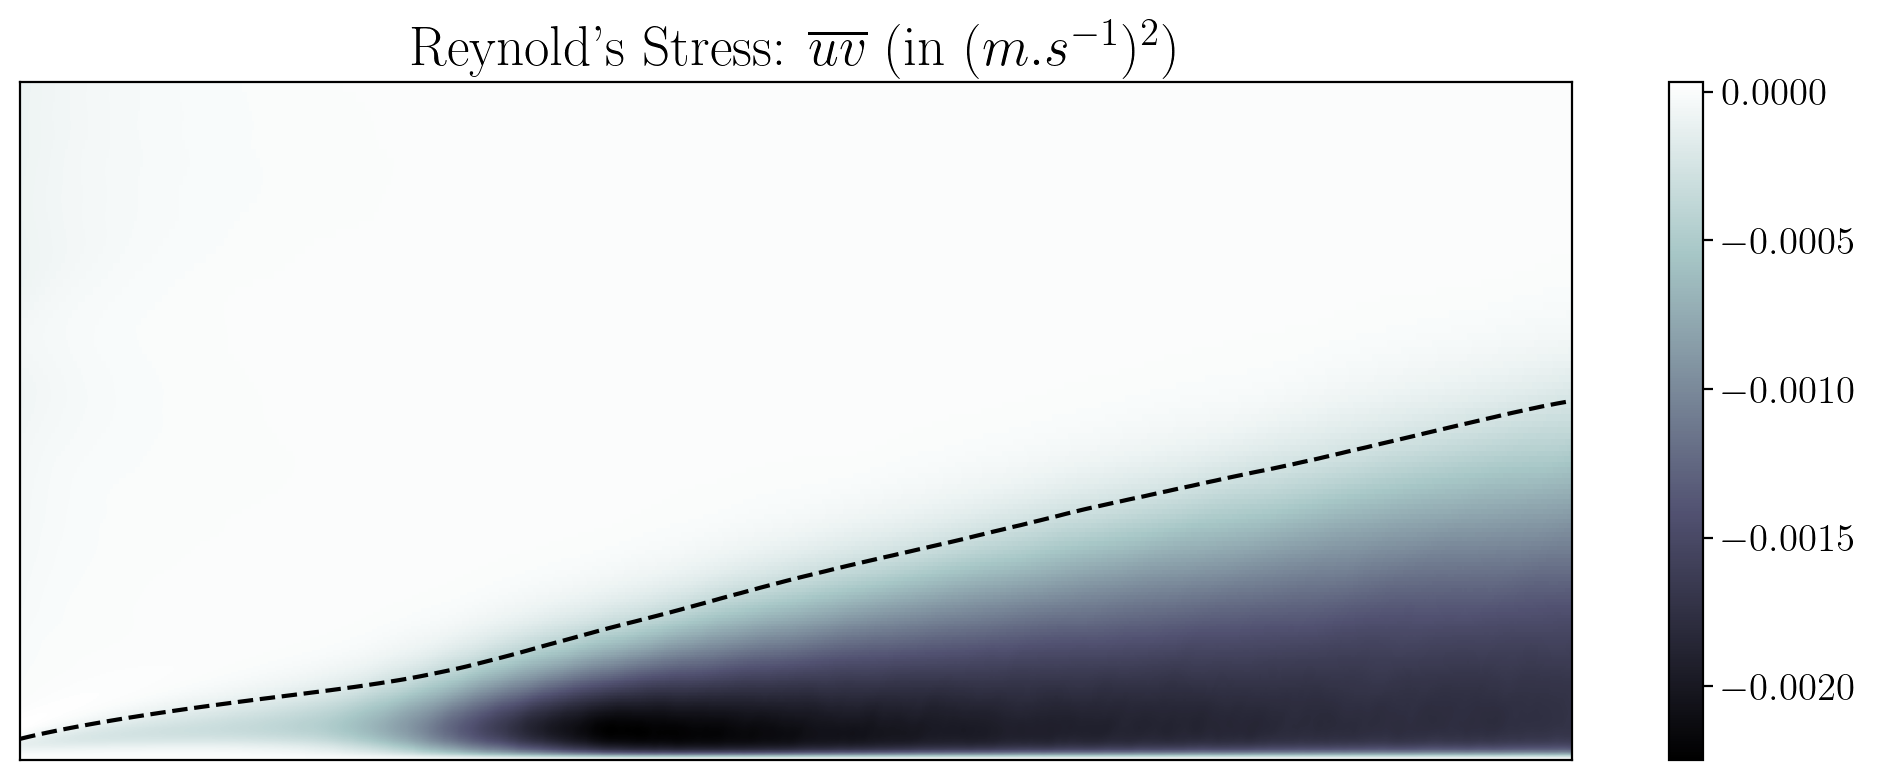

In [4]:
# Visualize by wall-normal Reynolds stress

X, Y = np.meshgrid(x, y)

# Include line of 99% of free flow mean velocity
# Values from http://turbulence.pha.jhu.edu/docs/README-transition_bl.pdf
U_inf = 1
nu = 1 / 800
Re = (U_inf / nu) * x

pf.plot_reynolds_stress(x, y, X, Y, u, Ruv)

## Get the finite difference derivatives to estimate the gradients

__NOTE: VARIABLE STEP SIZE IN Y DIRECTION ONLY__

In [5]:
# Get space steps

dx = x[1] - x[0]
dy = y[1:] - y[:-1]

nx = len(x)  # Number of points in x
ny = len(y)  # Number of points in y

%load_ext line_profiler


def get_derivatives(nx, ny, dx, dy):
    """Get the derivatives for the 2D domain

    Parameters:
    -----------
    nx: int
        Number of points in the x-direction
    ny: int
        Number of points in the y-direction
    dx: float
        Step in the x-direction
    dy: float
        Step in the y-direction

    Returns:
    --------
    Dx: sparse matrix
        2nd order derivative in the x-direction
    Dy: sparse matrix
        2nd order derivative in the y-direction
    """

    Dy = sparse.diags([-1, 1], [-1, 1], shape=(ny, ny)).toarray()

    # Get 2nd order forward/backwards at the boundaries
    Dy[0, :3] = np.array([-3, 4, -1])
    Dy[-1, -3:] = np.array([1, -4, 3])

    for i in range(ny - 1):
        Dy[i, :] = Dy[i, :] / (2 * dy[i])
    Dy[-1, :] = Dy[-1, :] / (2 * dy[-1])

    # Repeat this for the x-direction
    Dy = sparse.block_diag([Dy for i in range(nx)])  # Creates a block diagonal matrix
    # with the Dy matrix on the diagonal

    Dx = sparse.diags([-1, 1], [-ny, ny], shape=(nx * ny, nx * ny))
    Dx = sparse.lil_matrix(Dx)

    # Get 2nd order forwards/backwards with boundary conditions
    for i in range(ny):
        Dx[i, i] = -3
        Dx[i, ny + i] = 4
        Dx[i, 2 * ny + i] = -1
        Dx[-(i + 1), -(i + 1)] = 3
        Dx[-(i + 1), -(ny + i + 1)] = -4
        Dx[-(i + 1), -(2 * ny + i + 1)] = 1
    Dx = Dx / (2 * dx)

    Dx = sparse.csr_matrix(Dx)
    Dy = sparse.csr_matrix(Dy)

    return Dx, Dy


%lprun -f get_derivatives get_derivatives(nx, ny, dx, dy)

Timer unit: 1e-09 s

Total time: 12.5279 s
File: /var/folders/kt/m5clbvx50n37tx6gpnr84gd80000gn/T/ipykernel_66836/3844035954.py
Function: get_derivatives at line 12

Line #      Hits         Time  Per Hit   % Time  Line Contents
    12                                           def get_derivatives(nx, ny, dx, dy):
    13                                               """Get the derivatives for the 2D domain
    14                                           
    15                                               Parameters:
    16                                               -----------
    17                                               nx: int
    18                                                   Number of points in the x-direction
    19                                               ny: int
    20                                                   Number of points in the y-direction
    21                                               dx: float
    22                                  

In [6]:
Dx, Dy = get_derivatives(nx, ny, dx, dy)

In [7]:
Dxx = 2 * (Dx @ Dx)
Dyy = 2 * (Dy @ Dy)

In [8]:
# Flatten arrays for matrix multiplication, using fortran ordering
u = u.flatten("F")
v = v.flatten("F")
p = p.flatten("F")
Ruu = Ruu.flatten("F")
Ruv = Ruv.flatten("F")

In [9]:
# Get derivatives
ux = Dx @ u
uy = Dy @ u
vx = Dx @ v
vy = Dy @ v
px = Dx @ p
py = Dy @ p
lap_u = (Dxx + Dyy) @ u
Ruux = Dx @ Ruu
Ruvy = Dy @ Ruv

## 1. Visualising the RANS equation

In [10]:
# Labels of terms in the RANS equation
labels = [
    r"$\bar{u} \bar{u}_x$",
    r"$\bar{v}\bar{u}_y$",
    r"$\rho^{-1} \bar{p}_x$",
    r"$\nu \nabla^2 \bar{u}$",
    r"$\overline{(u^\prime v^\prime)}_y$",
    r"$\overline{({u^\prime} ^2)}_x$",
]

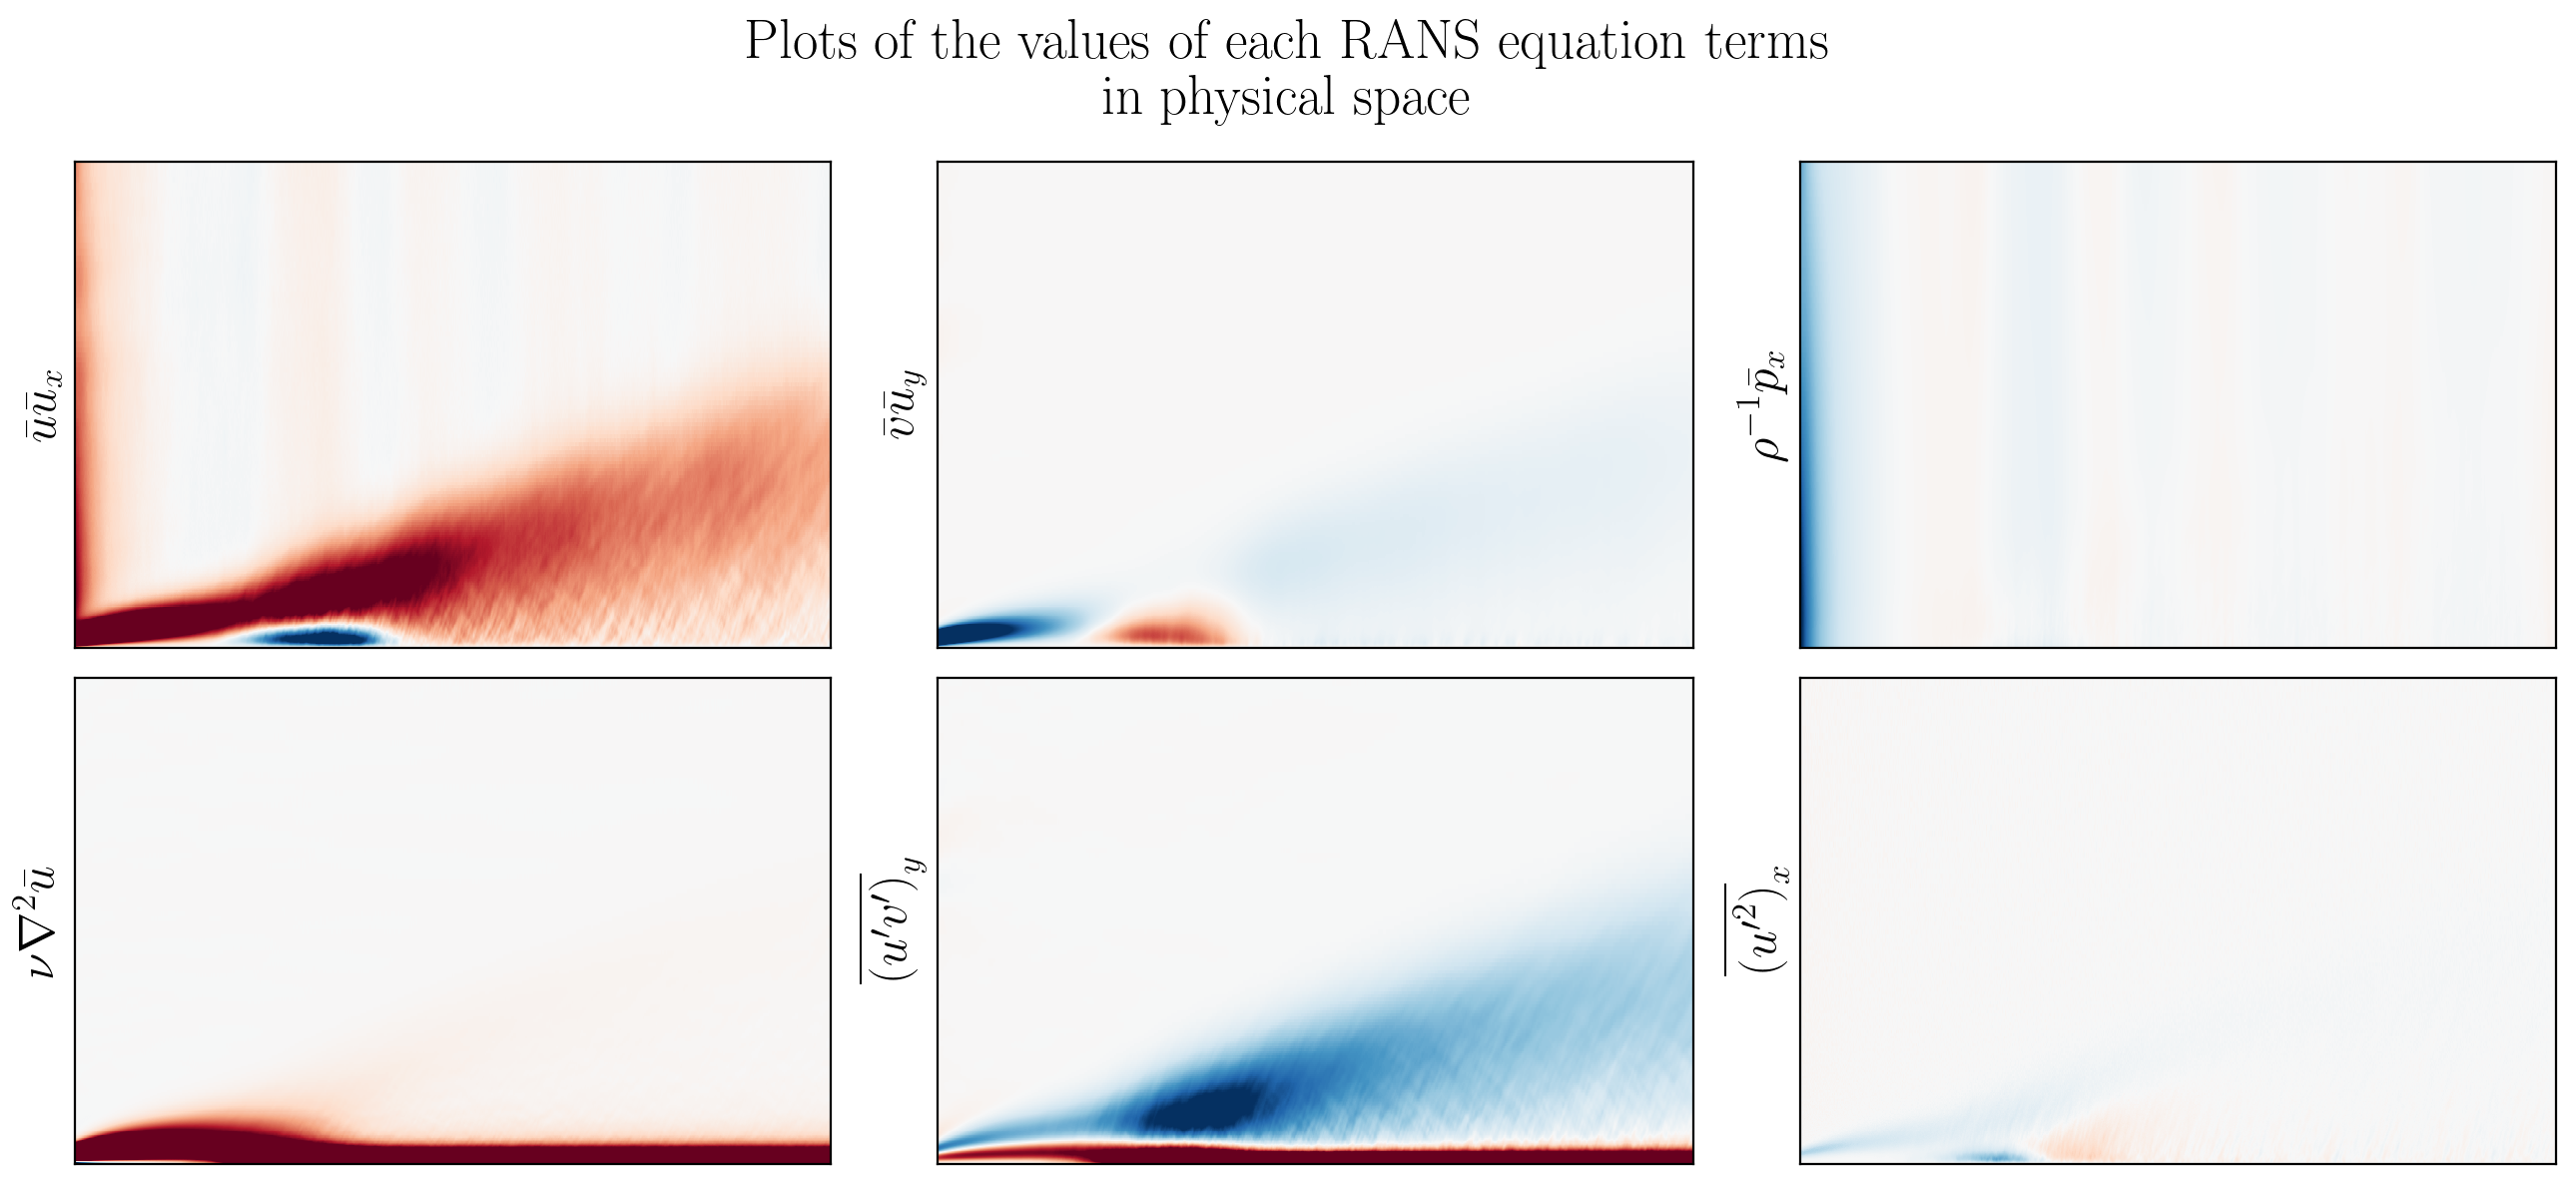

In [11]:
# Plot all six terms in the RANS equation
pf.plot_equation_terms_bound_lay(x, y, nx, ny, u, ux, uy, v, Ruvy, Ruux, px, nu, lap_u)

## 2. Cluster using Gaussian Mixture Model (GMM)

Since the data is very high resolution, train on 10% randomly subsampled points for better speed.

In [12]:
# Train Gaussian mixture model

# Gather the terms into an array of features
features = 1e3 * np.vstack([u * ux, v * uy, px, nu * lap_u, Ruvy, Ruux]).T
nfeatures = features.shape[1]

# Fit Gaussian mixture model
nc = 6  # Number of clusters
seed = 76016  #  Set a seed for debugging/plotting
model = GaussianMixture(n_components=nc, random_state=seed)

# Train on only a subset (10%) of the data
sample_pct = 0.1
mask = np.random.permutation(features.shape[0])[: int(sample_pct * features.shape[0])]
model.fit(features[mask, :])

GaussianMixture(n_components=6, random_state=76016)

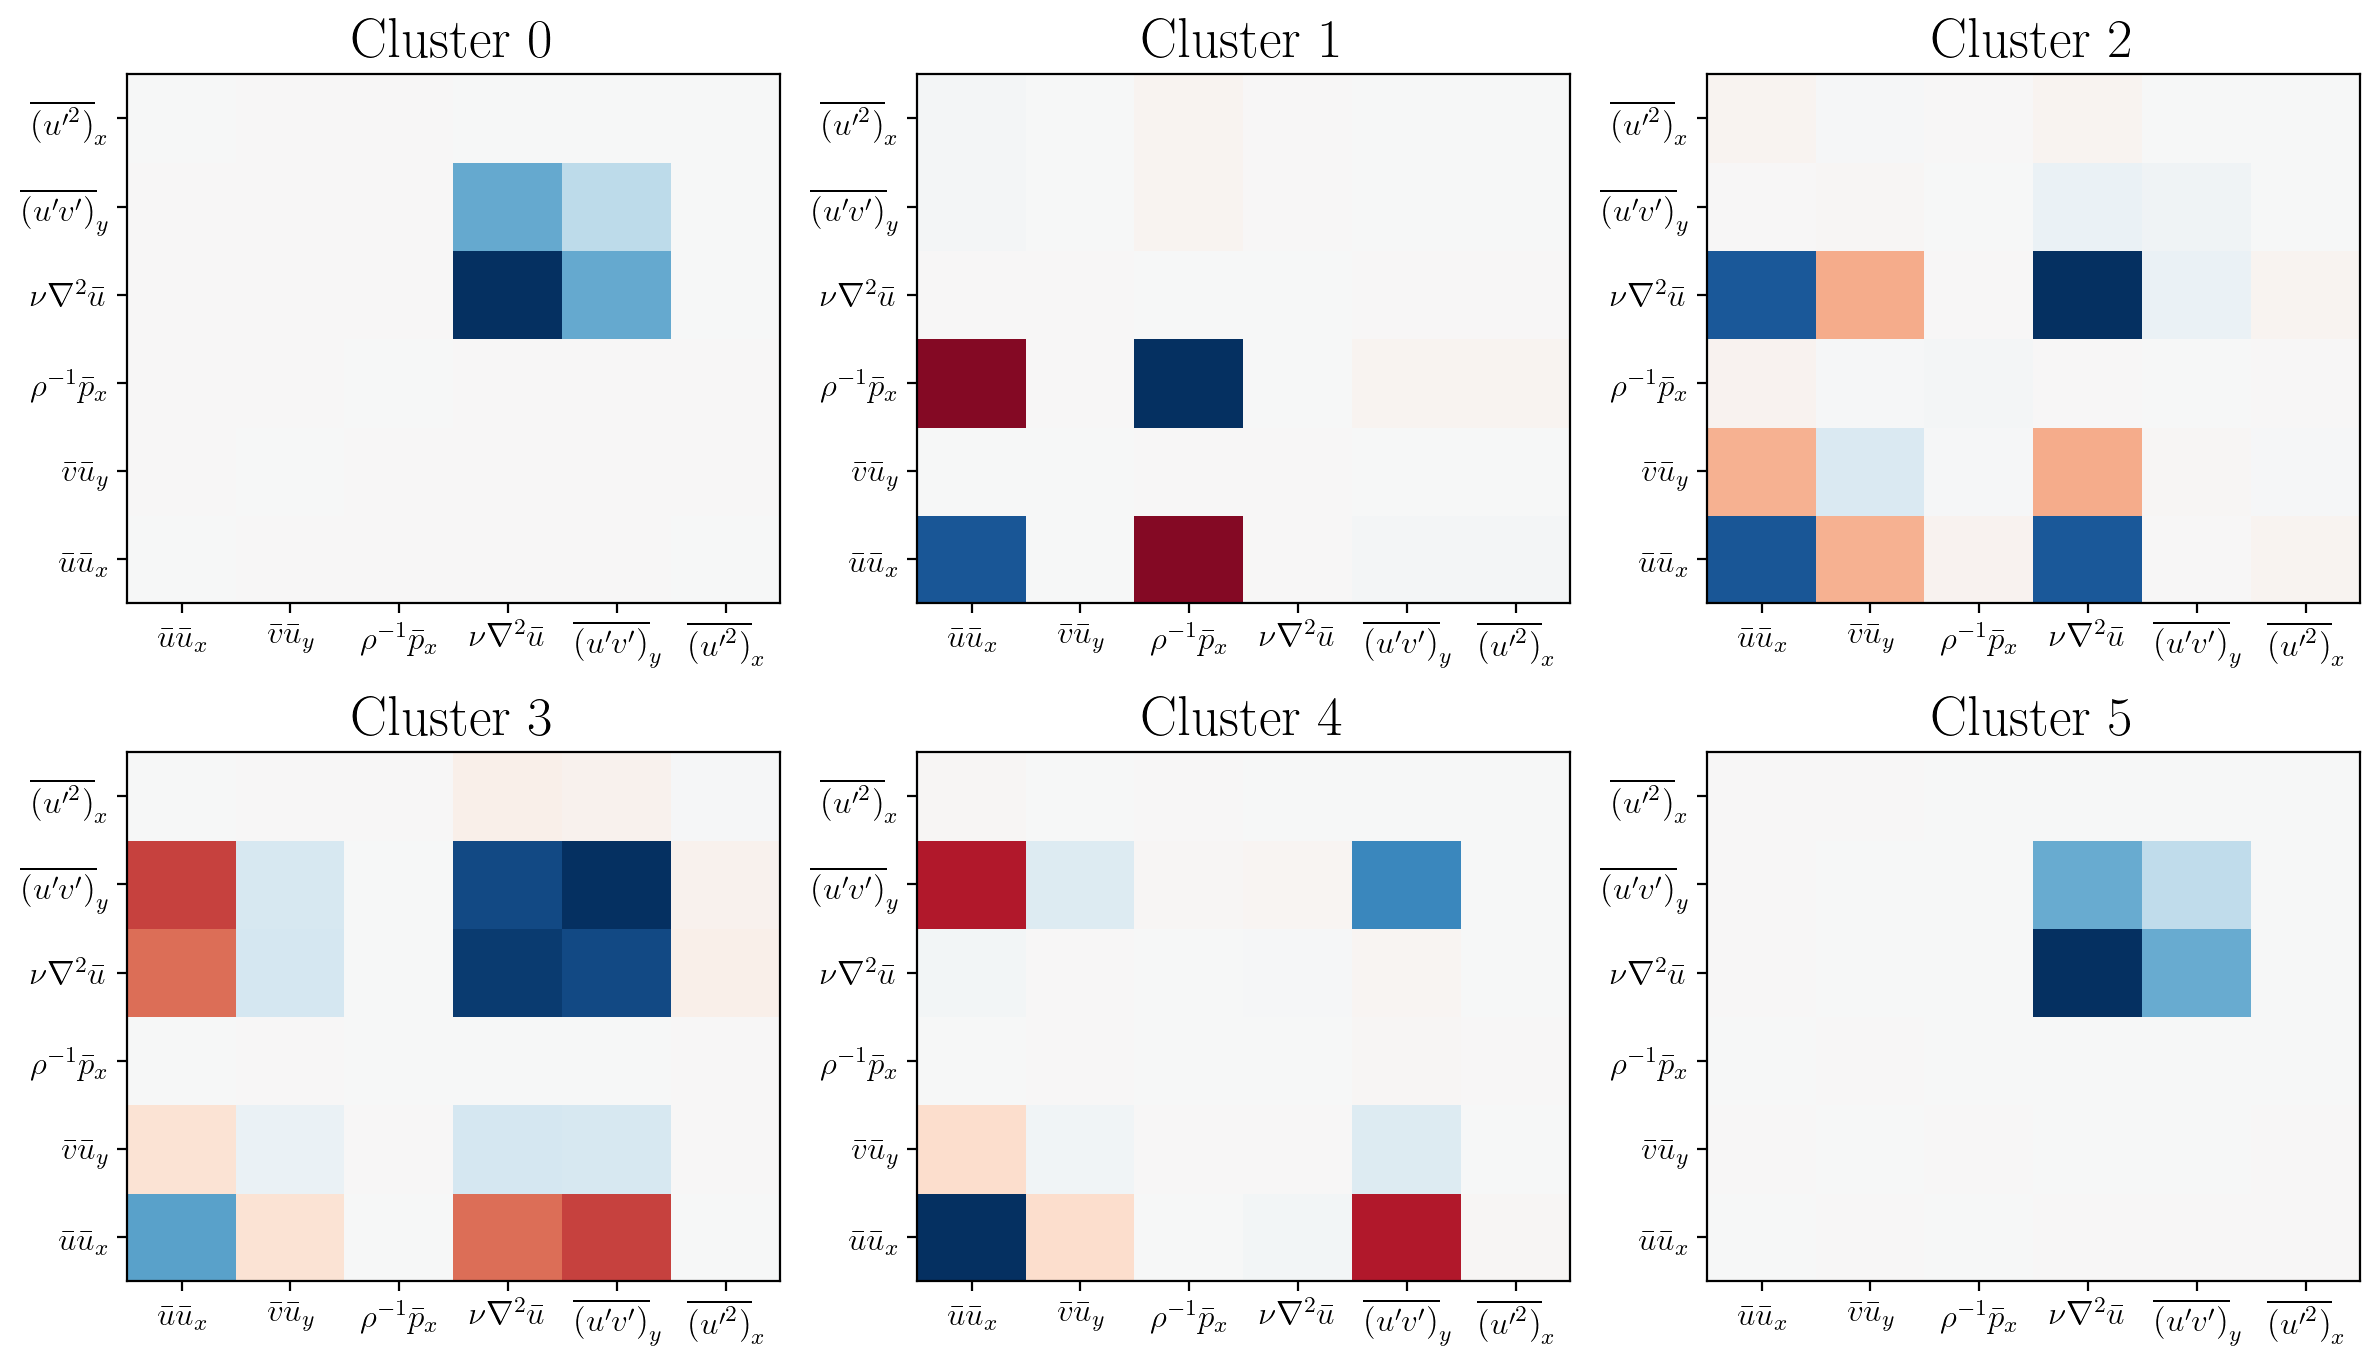

In [13]:
# Plot covariance matrices for each GMM cluster
pf.plot_cov_mat(model, nfeatures, nc, "GMM")

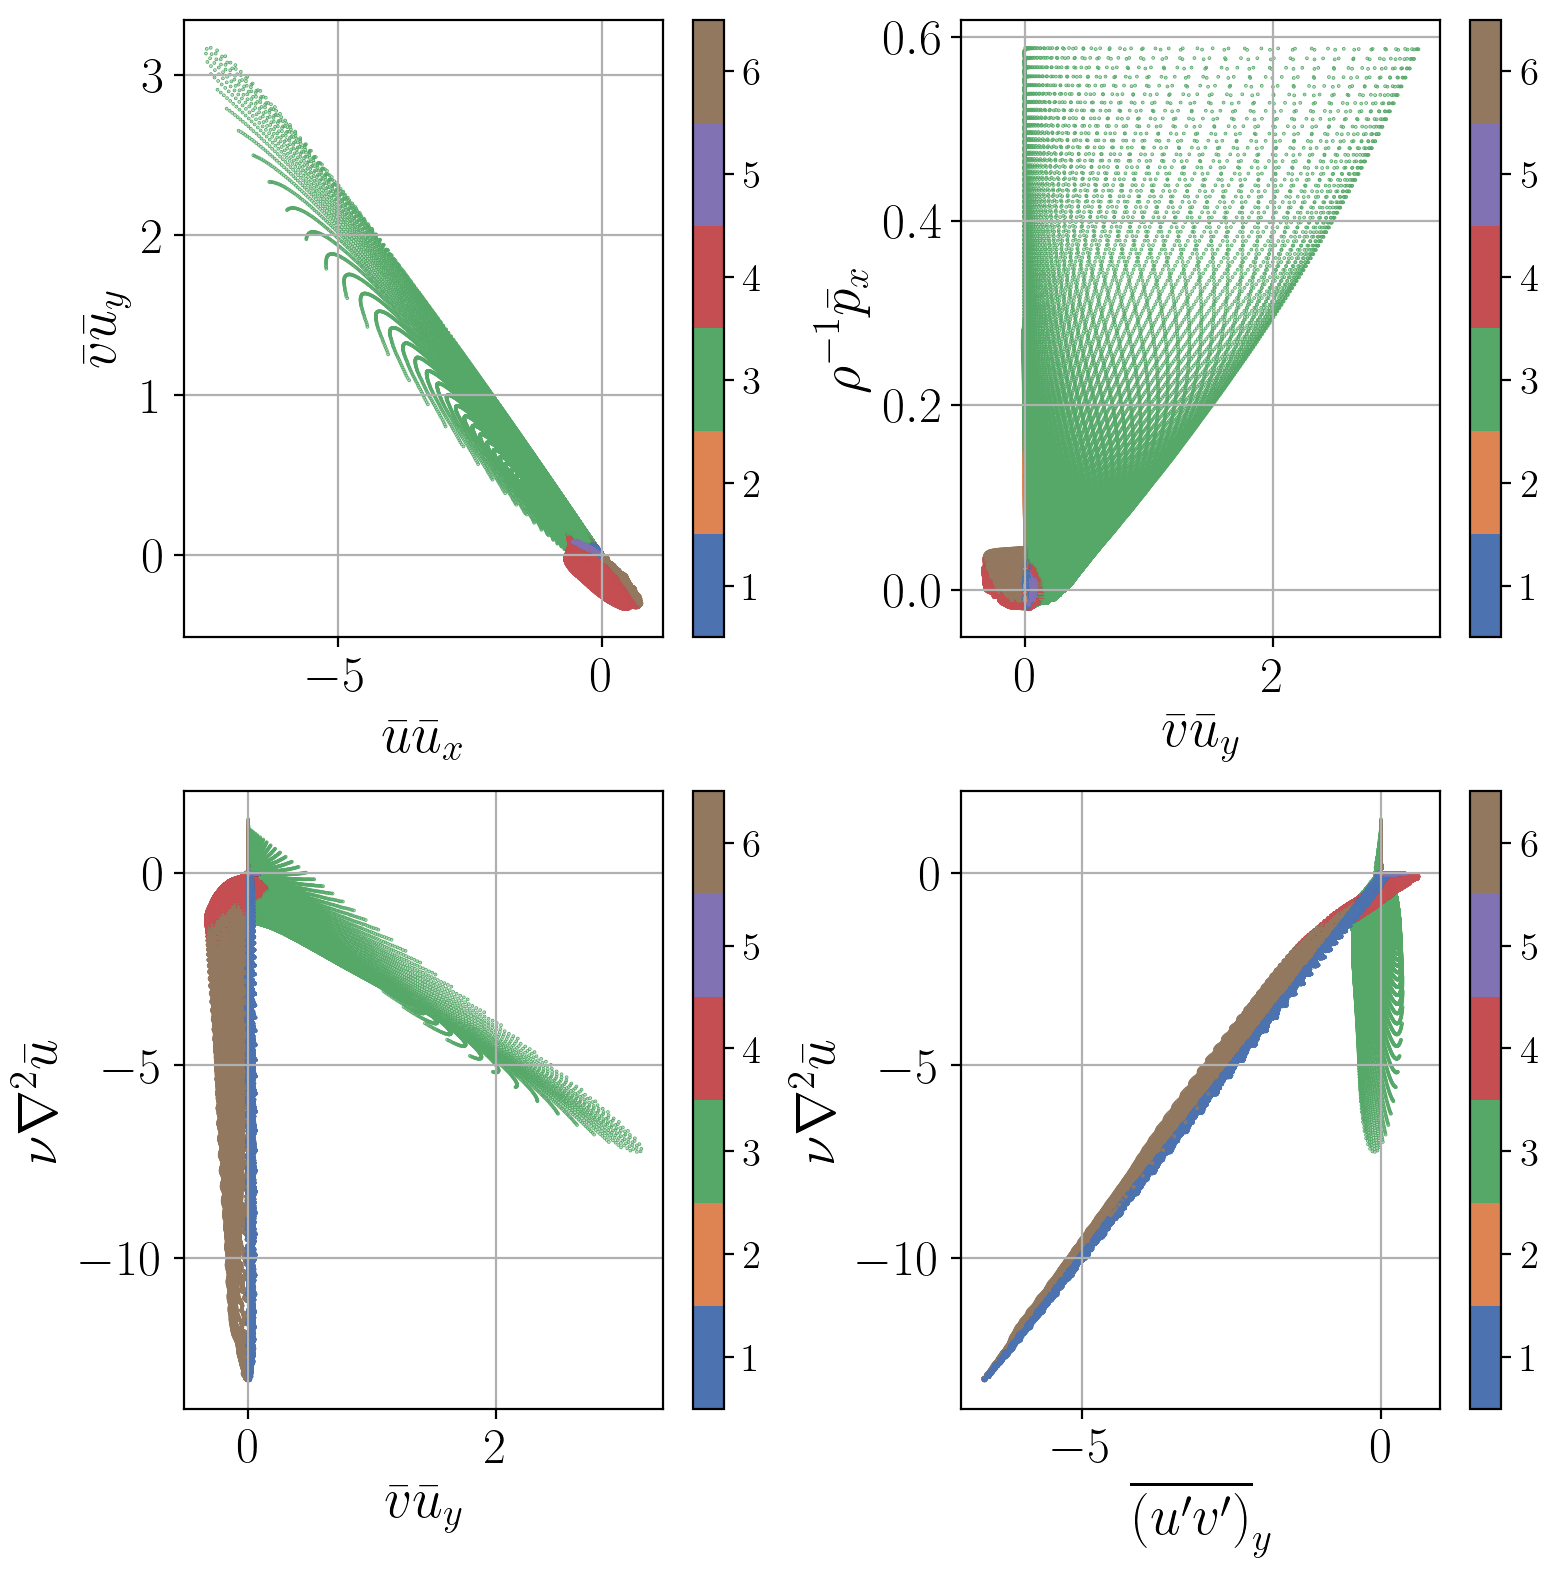

In [14]:
# Visualize GMM clustering with 2D views of equation space

cluster_idx = model.predict(features) + 1
clim = [0.5, cm.N - 0.5]
bounds = np.arange(0.5, nc + 1.5)

pf.plot_clustering_2d_eq_space(features, cluster_idx, nc)

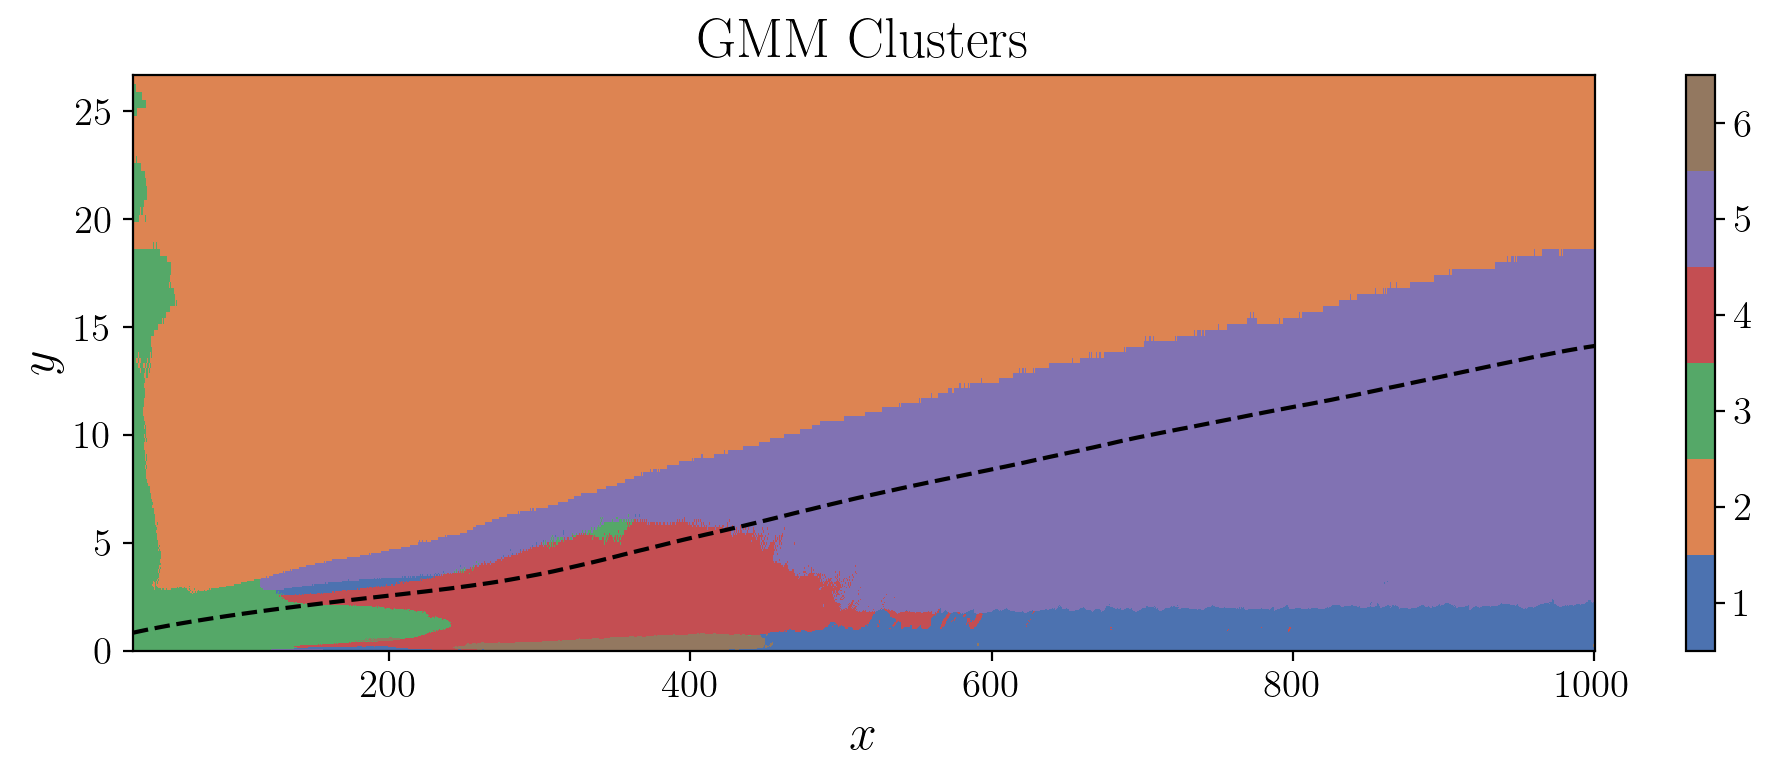

In [15]:
# Assign points in space to each cluster
cluster_idx = model.predict(features)
clustermap = np.reshape(cluster_idx, [ny, nx], order="F")

# Visualize the clustering in space
pf.plot_clustering_space(clustermap, x, y, X, Y, nx, ny, nc, u, U_inf)

## 3. Sparce Principal Component Analysis (SPCA) dimensionality reduction

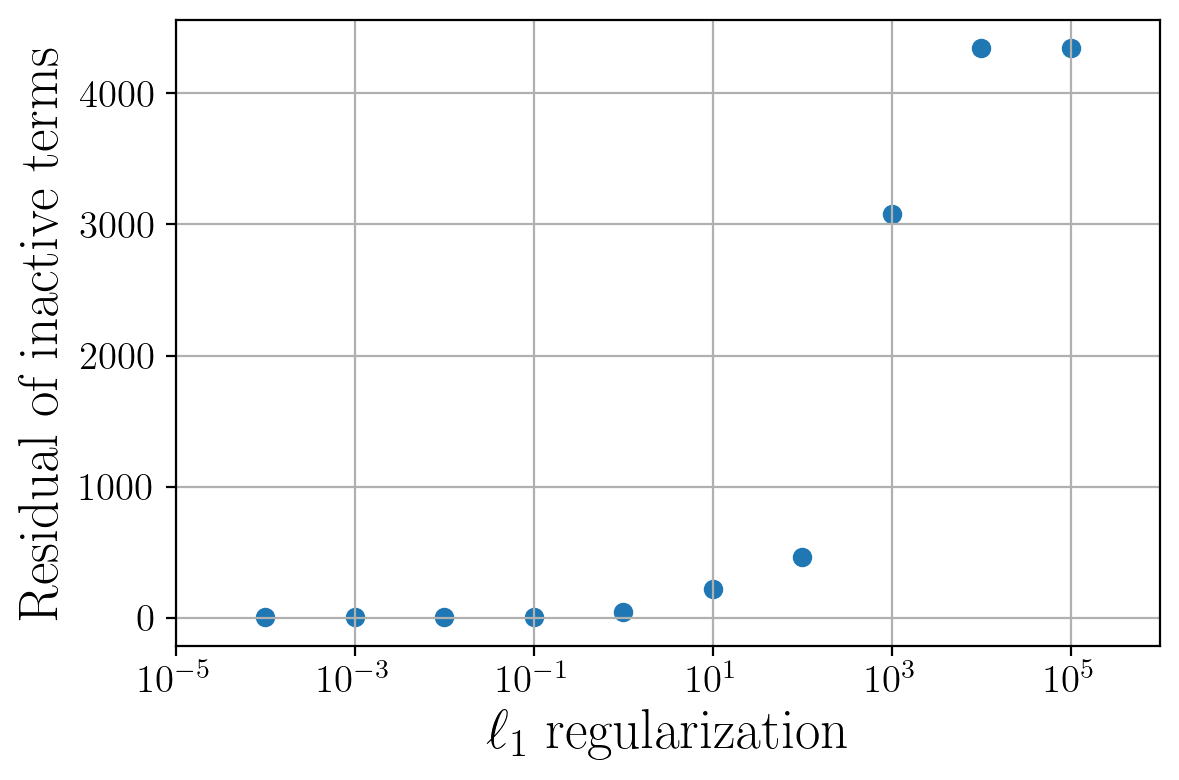

In [16]:
# Sparse PCA to identify directions of nonzero variance in each cluster

alphas = [1e-4, 1e-3, 1e-2, 0.1, 1, 10, 100, 1e3, 1e4, 1e5]
err = np.zeros([len(alphas)])
sparsity = np.zeros([len(alphas)])

for k in range(len(alphas)):
    for i in range(nc):
        # Identify points in the field corresponding to each cluster
        feature_idx = np.nonzero(cluster_idx == i)[0]
        cluster_features = features[feature_idx, :]

        # Conduct Sparse PCA
        spca = SparsePCA(n_components=1, alpha=alphas[k])  # normalize_components=True
        spca.fit(cluster_features)

        # Identify active and terms
        active_terms = np.nonzero(spca.components_[0])[0]
        inactive_terms = [feat for feat in range(nfeatures) if feat not in active_terms]

        # Calculate the error, as the sum of the norms of the inactive terms
        err[k] += np.linalg.norm(cluster_features[:, inactive_terms])

pf.plot_spca_residuals(alphas, err)

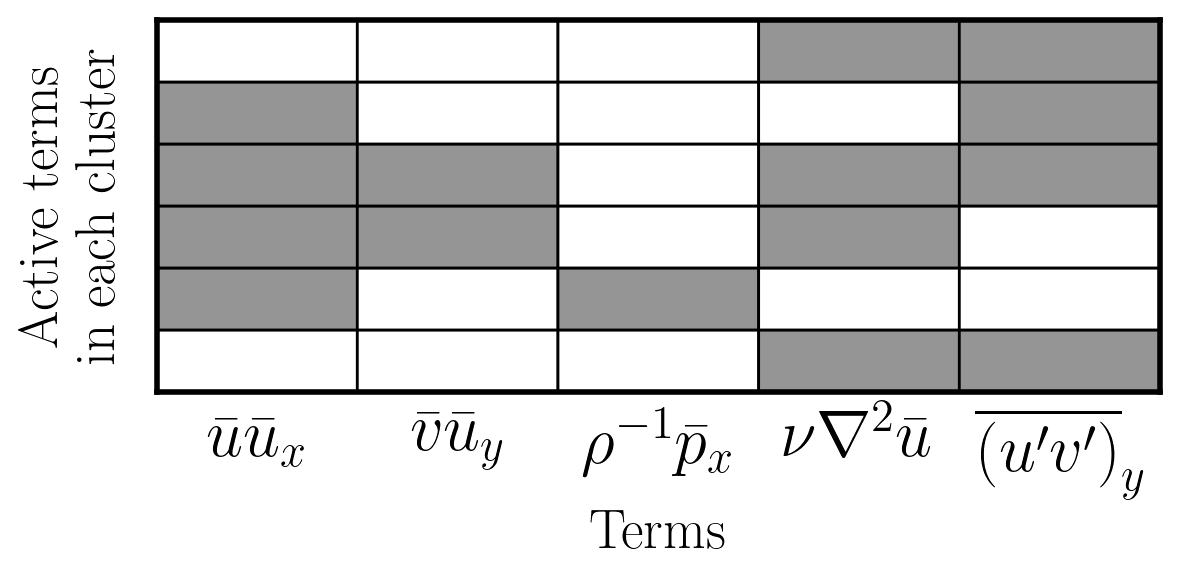

In [17]:
# Get the active terms for each cluster for optimal alpha

alpha_opt = 10  # Optimal alpha value

spca_model = np.zeros([nc, nfeatures])  # Store the active terms for each cluster

for i in range(nc):
    feature_idx = np.nonzero(cluster_idx == i)[0]
    cluster_features = features[feature_idx, :]

    spca = SparsePCA(n_components=1, alpha=alpha_opt)  # normalize_components=True
    spca.fit(cluster_features)

    active_terms = np.nonzero(spca.components_[0])[0]
    if len(active_terms) > 0:
        spca_model[i, active_terms] = 1  # Set the active terms to 1

pf.plot_active_terms(spca_model, labels)

## 4. Resulting Final Dominant Balance Models

In [18]:
# Identify clusters with identical balance models
balance_models, model_index = np.unique(spca_model, axis=0, return_inverse=True)
nmodels = balance_models.shape[0]
print(balance_models)

# Print balance models
for i in range(nmodels):
    print("SPCA Cluster {0}:".format(i))
    active_terms = np.nonzero(balance_models[i, :])[0]
    if len(active_terms) > 0:
        print([labels[k] for k in active_terms])
    else:
        print("No dynamics")

# Make new cluster_idx based on the unique SPCA balance model
balance_idx = np.array([model_index[i] for i in cluster_idx])
balancemap = np.reshape(balance_idx, [ny, nx], order="F")

[[0. 0. 0. 1. 1. 0.]
 [1. 0. 0. 0. 1. 0.]
 [1. 0. 1. 0. 0. 0.]
 [1. 1. 0. 1. 0. 0.]
 [1. 1. 0. 1. 1. 0.]]
SPCA Cluster 0:
['$\\nu \\nabla^2 \\bar{u}$', '$\\overline{(u^\\prime v^\\prime)}_y$']
SPCA Cluster 1:
['$\\bar{u} \\bar{u}_x$', '$\\overline{(u^\\prime v^\\prime)}_y$']
SPCA Cluster 2:
['$\\bar{u} \\bar{u}_x$', '$\\rho^{-1} \\bar{p}_x$']
SPCA Cluster 3:
['$\\bar{u} \\bar{u}_x$', '$\\bar{v}\\bar{u}_y$', '$\\nu \\nabla^2 \\bar{u}$']
SPCA Cluster 4:
['$\\bar{u} \\bar{u}_x$', '$\\bar{v}\\bar{u}_y$', '$\\nu \\nabla^2 \\bar{u}$', '$\\overline{(u^\\prime v^\\prime)}_y$']


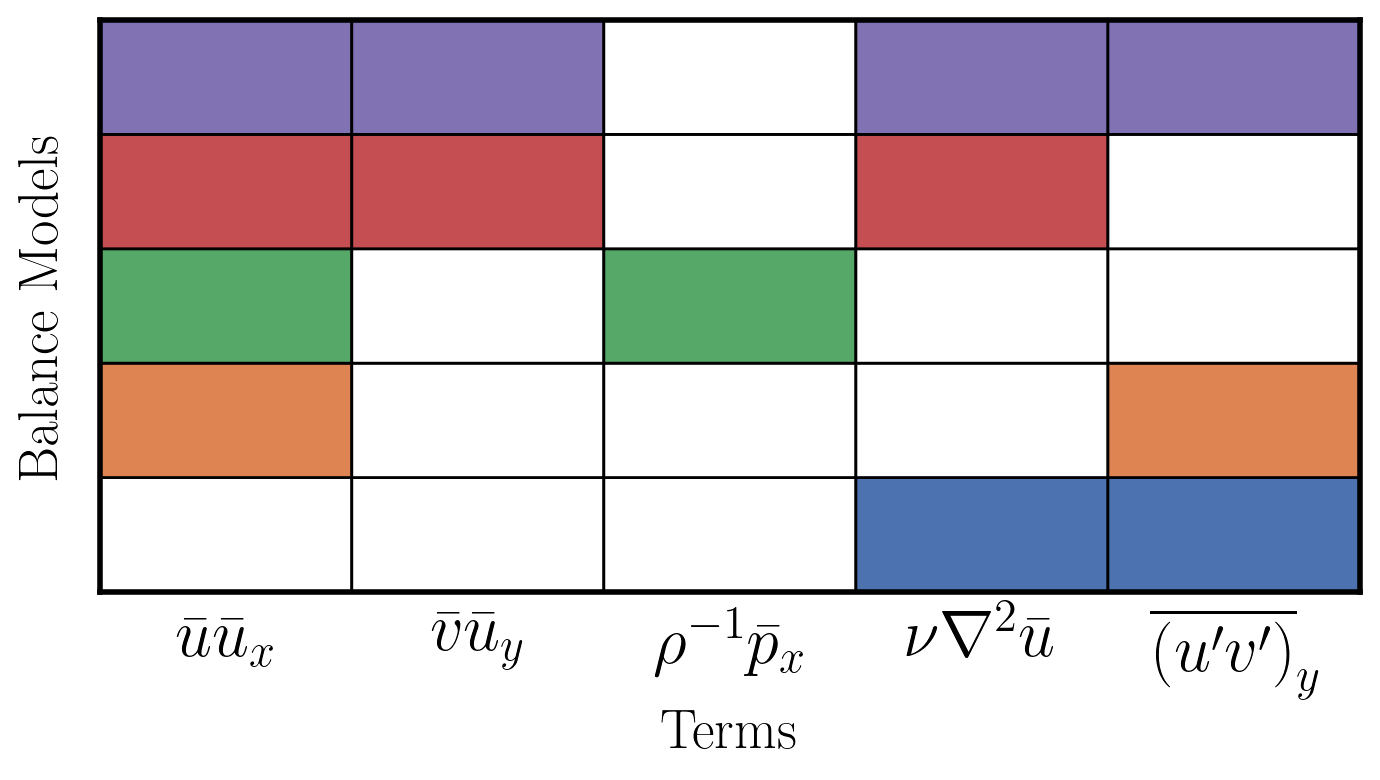

In [19]:
# Plot a grid with active terms in each cluster
gridmap = balance_models.copy()
gridmask = gridmap == 0
gridmap = (gridmap.T * np.arange(nmodels)).T + 1
gridmap[gridmask] = 0

# Delete unused terms
grid_mask = np.nonzero(np.all(gridmap == 0, axis=0))[0]
gridmap = np.delete(gridmap, grid_mask, axis=1)
grid_labels = np.delete(labels, grid_mask)

pf.plot_balance_models(gridmap, grid_labels)

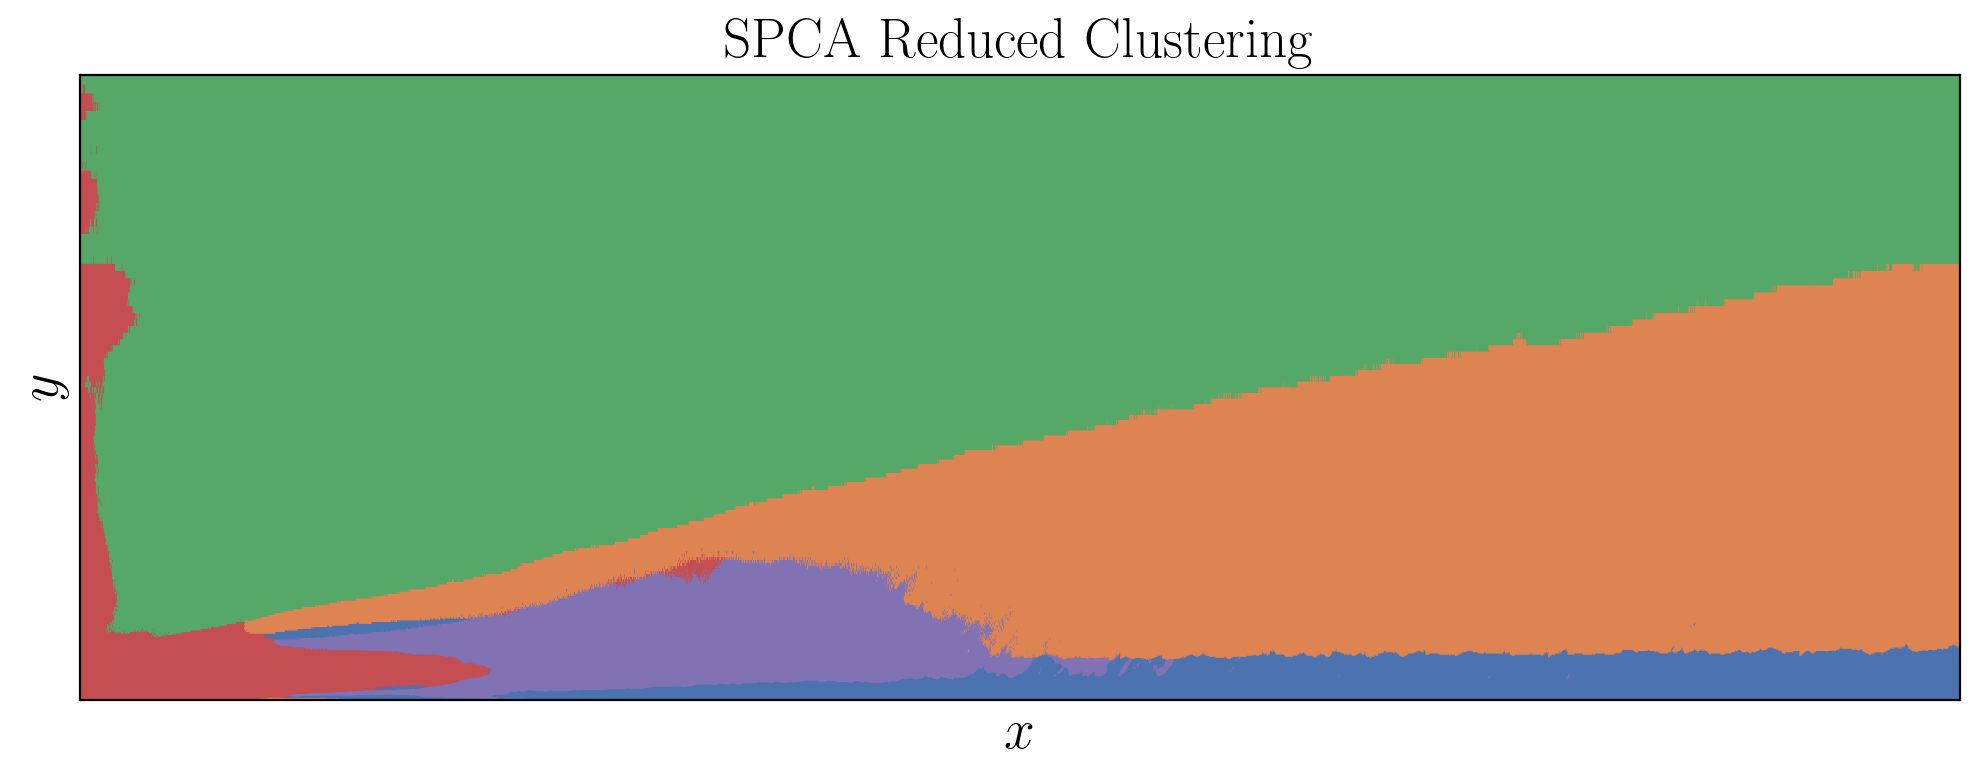

In [20]:
# Plot the clustering in space after SPCA
pf.plot_spca_reduced_clustering(x, y, balancemap)

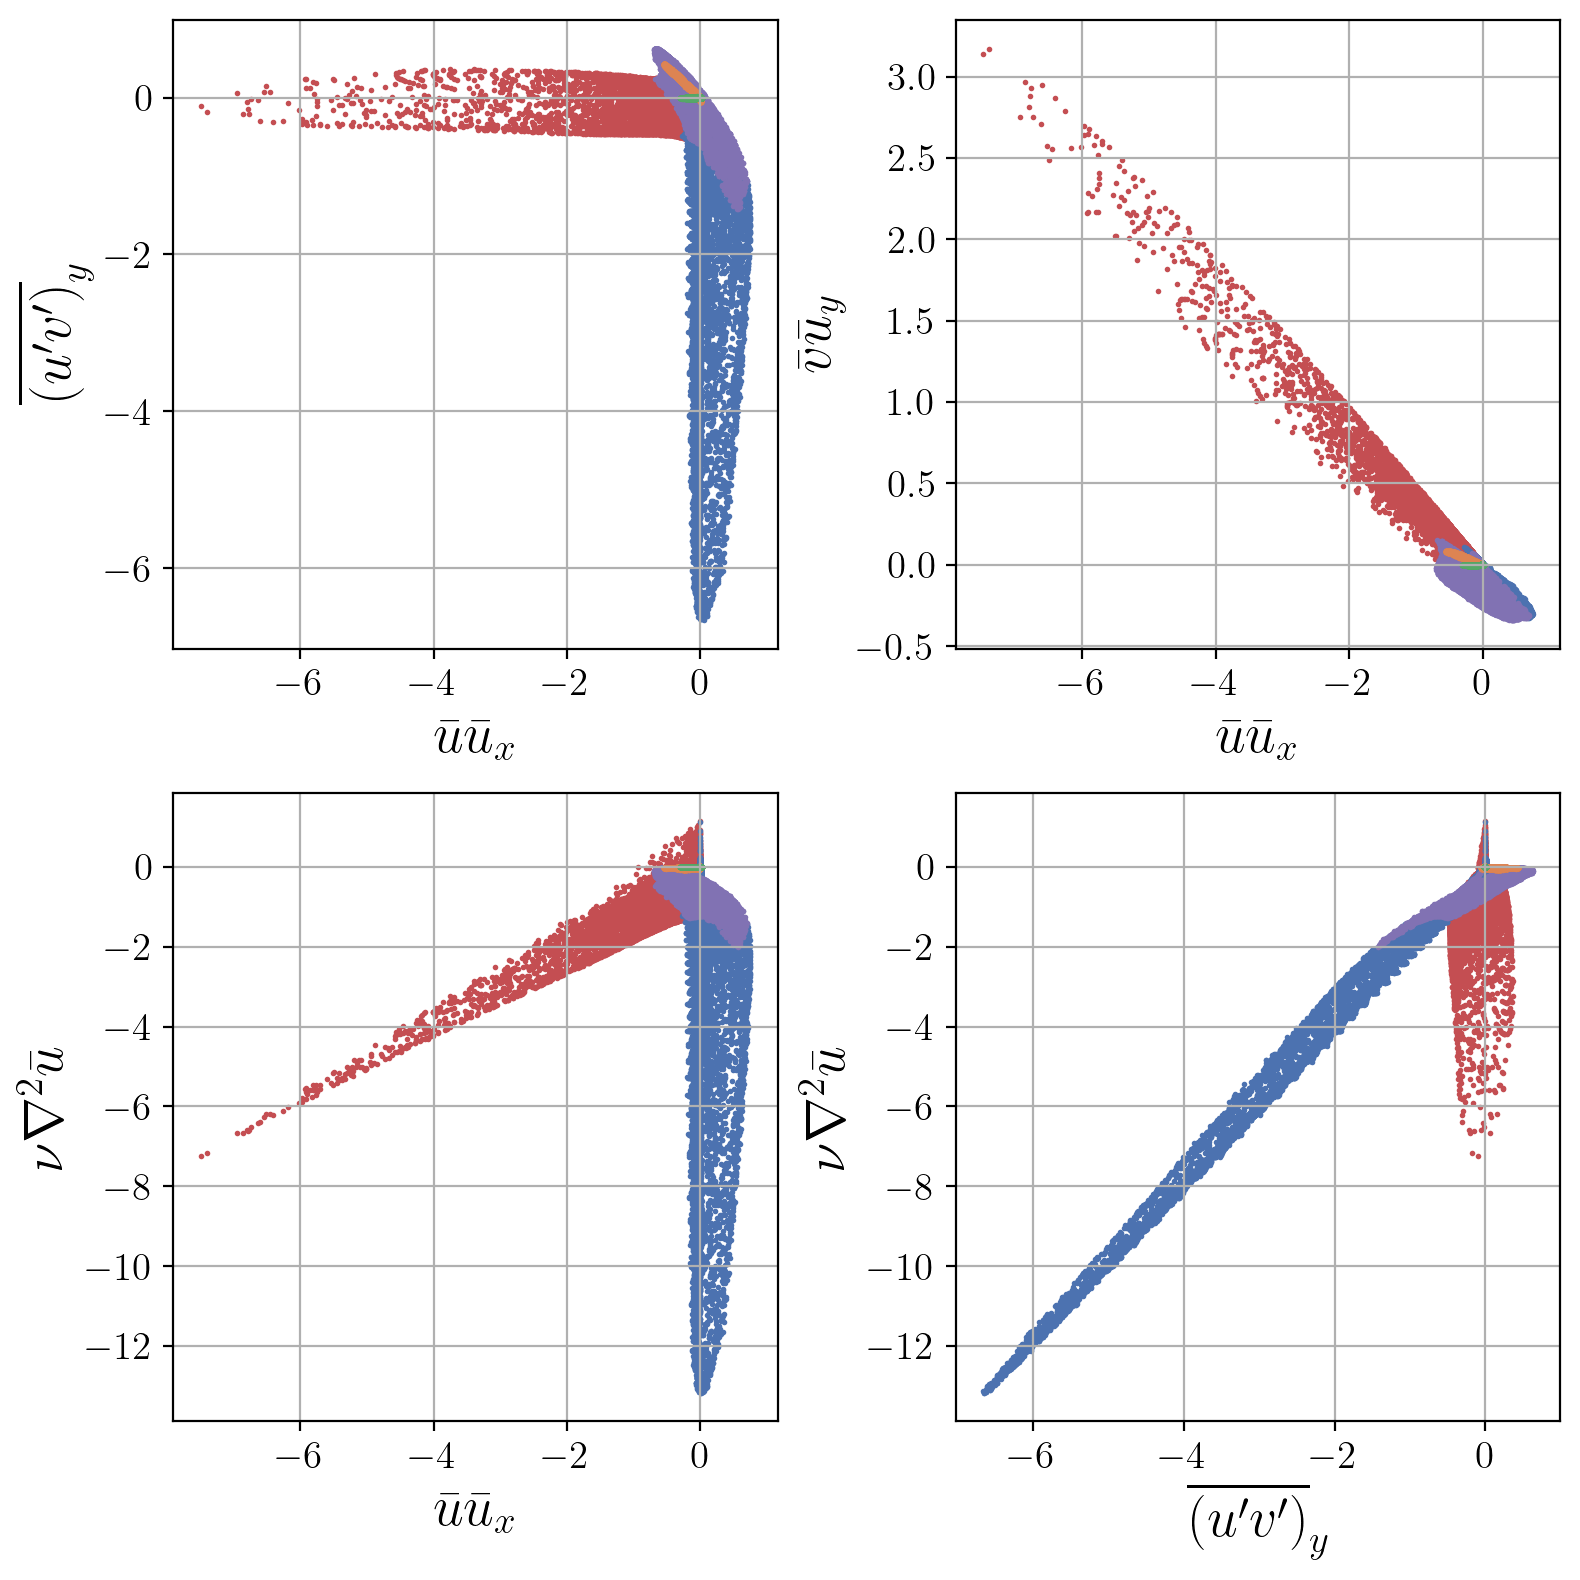

In [21]:
# 2D views of feature space
pf.plot_feature_space(features[mask, :], balance_idx[mask])

## Outer Layer Scaling

The length scale of the outer layer should scale with $ \ell \sim x^{4/5} $ (see pg 71 in Holmes, Lumley, Berkooz or pg 638 in Schlichting)

As a rough diagnostic of our balance model, define the outer layer length scale as the wall-normal coordinate where the balance changes from the inertial sublayer to the free-stream (once the transitional region has disappeared).

[0.0679616  0.81339422]


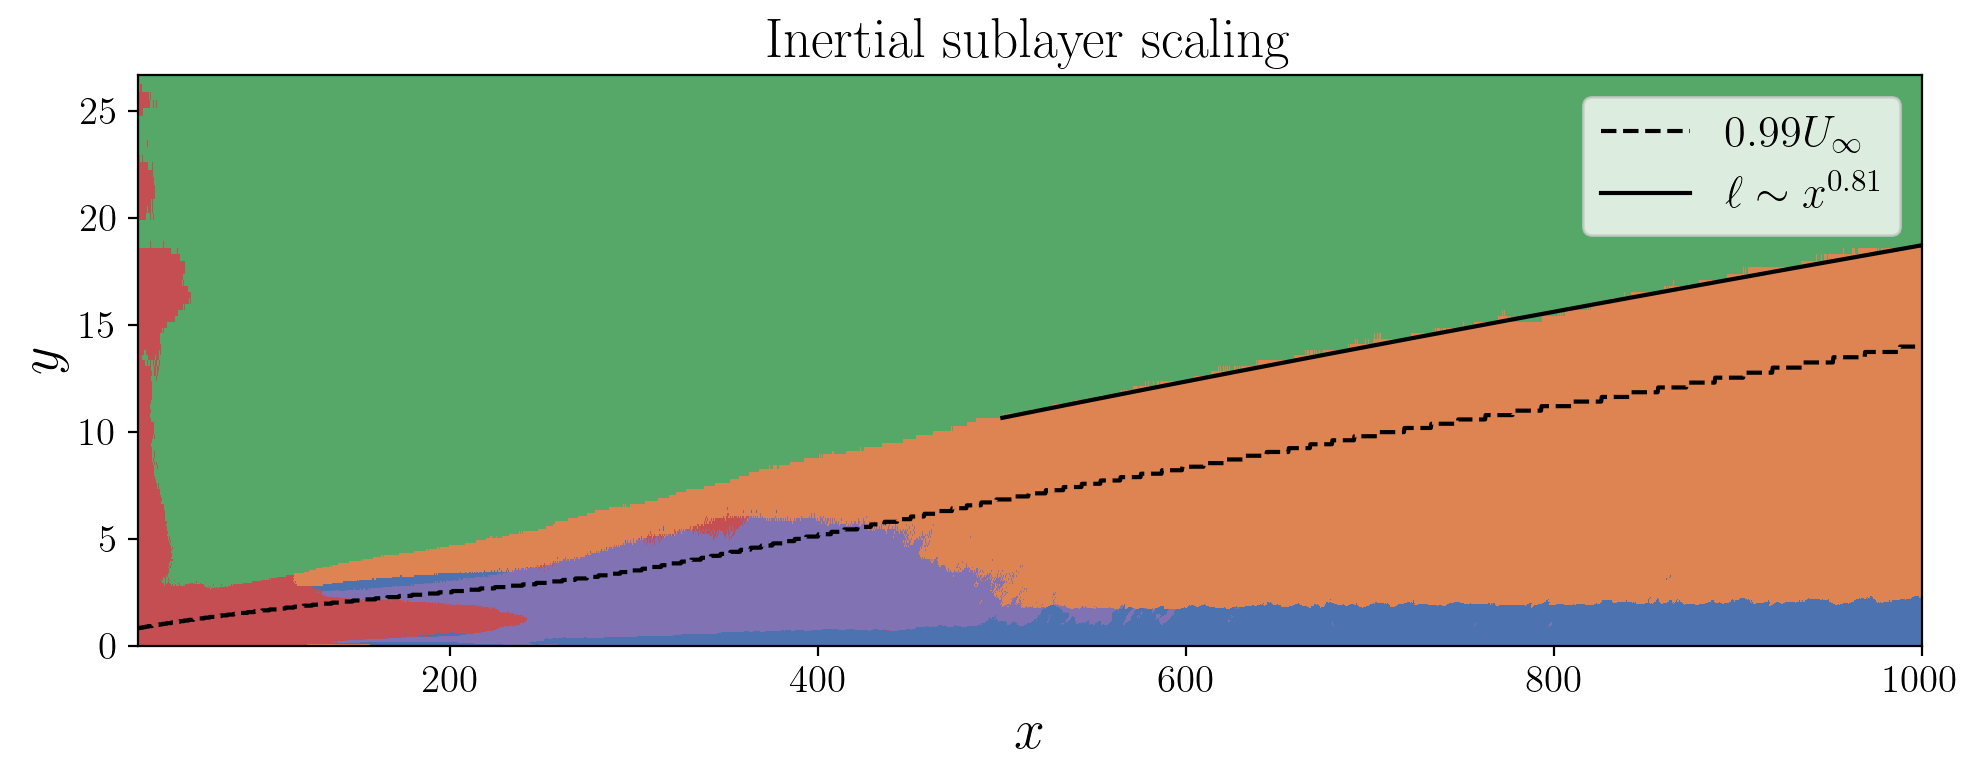

In [22]:
# Define some variables
u_map = np.reshape(u, (ny, nx), order="F")

x_min = 110  # Where inertial balance begins
x_turb = 500  # Where transitional region ends

x_idx = np.nonzero(x > x_min)[0]
x_layer = x[x_idx]

# First, find the upper extent of the inertial sublayer
y_gmm = np.zeros(len(x_idx))
# Loop through wall-normal direction until the balance changes
for i in range(len(x_idx)):
    j = len(y) - 1
    while balancemap[j, x_idx[i]] == 2:
        j -= 1
    y_gmm[i] = y[j]  # Store upper value of inertial balance

# Next, find the 99% of free stream velocity line
delta = np.zeros(len(x))
# Loop until velocity falls past 99% freestream
for i in range(len(x)):
    j = 0
    while u_map[j, i] < 0.99:
        j += 1
    delta[i] = y[j - 1]

# Fit inertial balance to power law
power_law = lambda x, a, b: a * x**b

x_to_fit = x_layer > x_turb  # End of transitional region
p_gmm, cov = curve_fit(power_law, x_layer[x_to_fit], y_gmm[x_to_fit])
gmm_fit = power_law(x_layer, *p_gmm)
print(p_gmm)

# Plot the inertial sublayer scaling
pf.plot_sublayer_scaling(x, y, balancemap, delta, x_layer, gmm_fit, p_gmm, x_to_fit)

## Self-similarity

In the near-wall region (viscous sublayer), we should be able to collapse the profiles using wall units $u^+$, $y^+$. These wall units are defined as: 
- $y^{+}=\frac{y u_{\tau}}{\nu}$, the distance $y$ to the wall, dimensionaless using friction velocity $u_{\tau}$, and kinematic viscosity $\nu$.
- $u^{+}=\frac{u}{u_{\tau}}$, the dimensonless velocity as a function of y.

Here we show that this universality breaks down at approximately the same place where the identified viscous sublayer balance ends. Therefore demonstrating the identified balance models follow fluid dynamics theory.

As shown in the figure above, the wall-normal extent of the sublayer (blue) is approximately constant in the fully-developed turbulent region. We show below that this corresponds to $y^+ \sim 70$.

[Wikipedia](https://en.wikipedia.org/wiki/Law_of_the_wall)

1950
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87]
67.12890296841488
2293
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91]
72.05141550893792
2635
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90]
68.78122103870986
2977
[ 0  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 

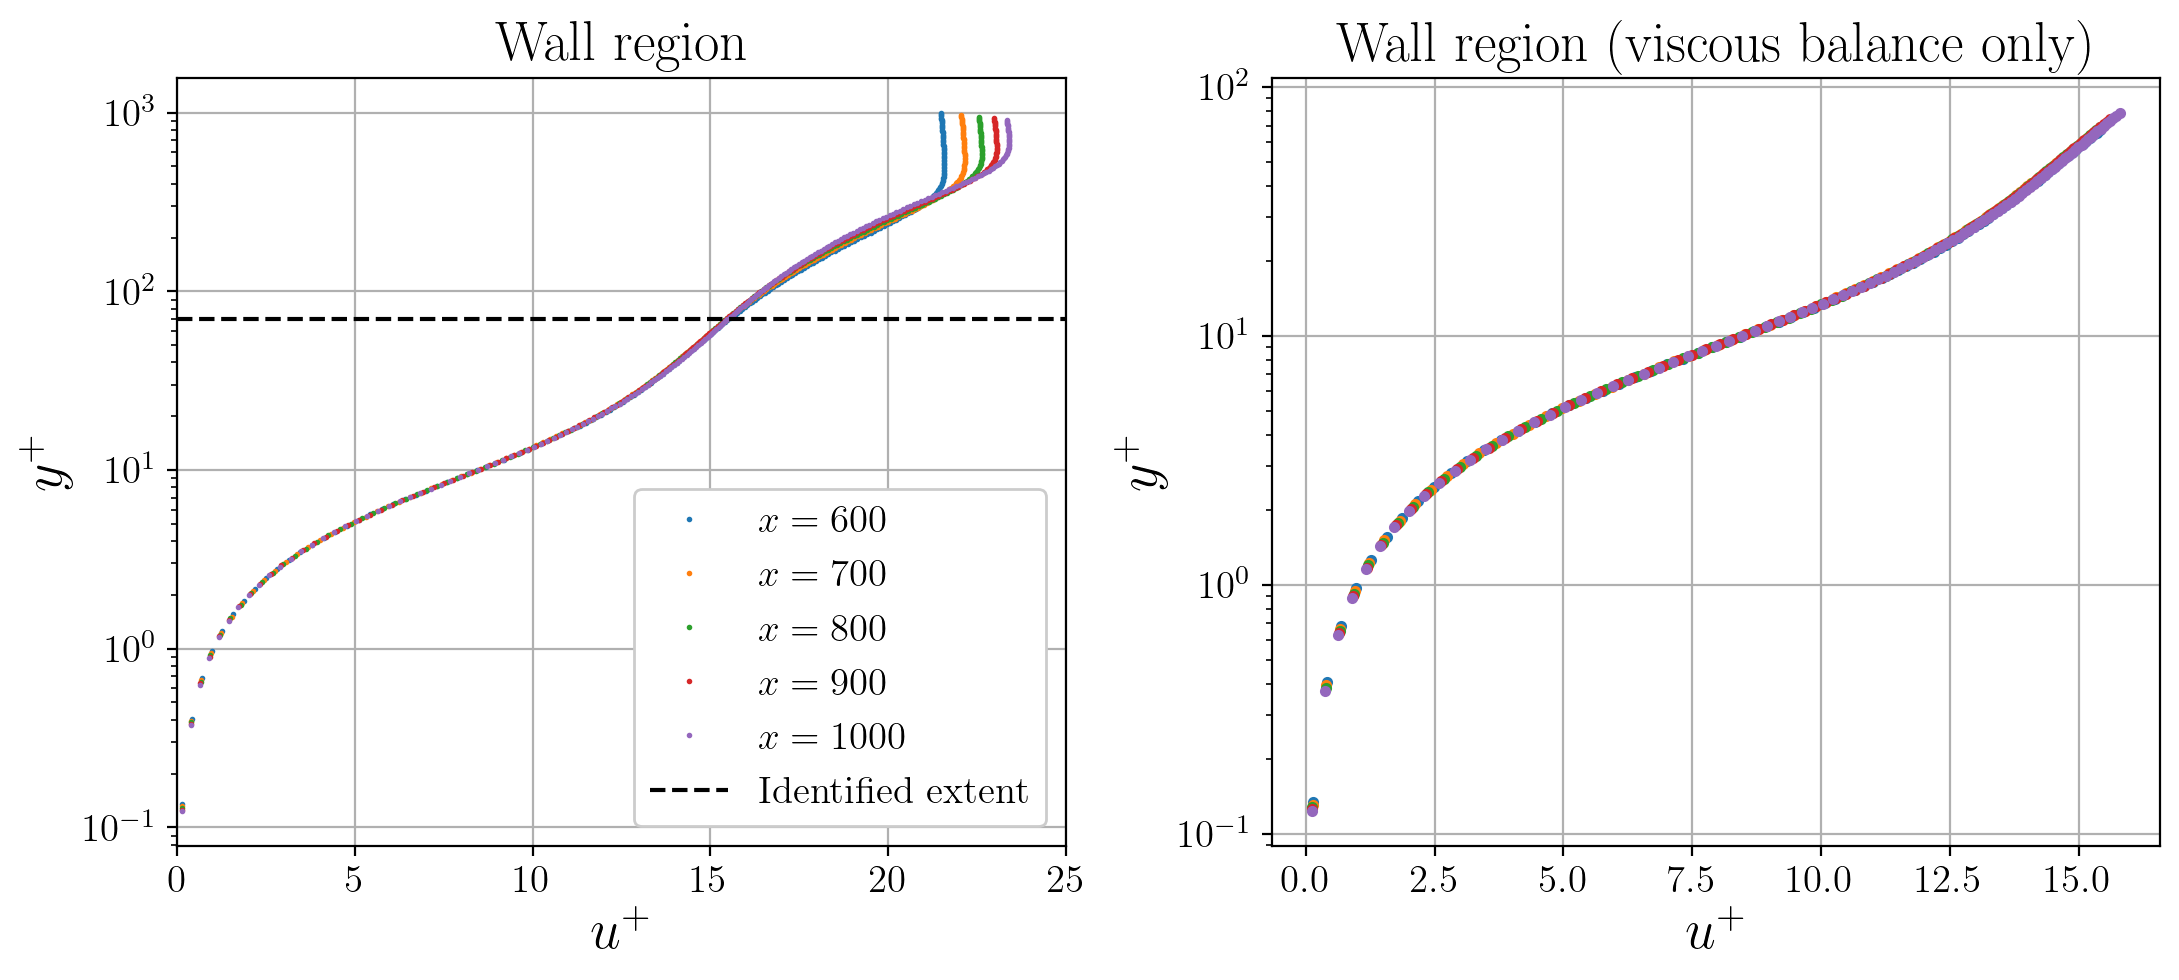

In [23]:
# Compute friction velocity with an estimate of the wall shear stress
u_tau = np.sqrt(nu * uy[::ny])

# Define wall units
y_plus = np.outer(y, u_tau / nu)
u_plus = np.reshape(u, [ny, nx], order="F") / u_tau

# Plot the self-similarity of the flow
pf.plot_self_similarity(x, 0, y_plus, u_plus, balancemap)

## Blasius solution in laminar regime

We also find that there is an inflow region without significant Reynolds stress (red), which suggests this flow is approximately laminar, until the transitional (orange) region begins around $x\sim 105$.  Before that we would expect the Blasius boundary layer solution to hold.

__Blasius solution:__
$$ \eta = y \sqrt{\frac{U}{2\nu x} }$$
$$ u = U f'(\eta) $$
[Wikipedia](https://en.wikipedia.org/wiki/Blasius_boundary_layer#Blasius_equation_-_first-order_boundary_layer)

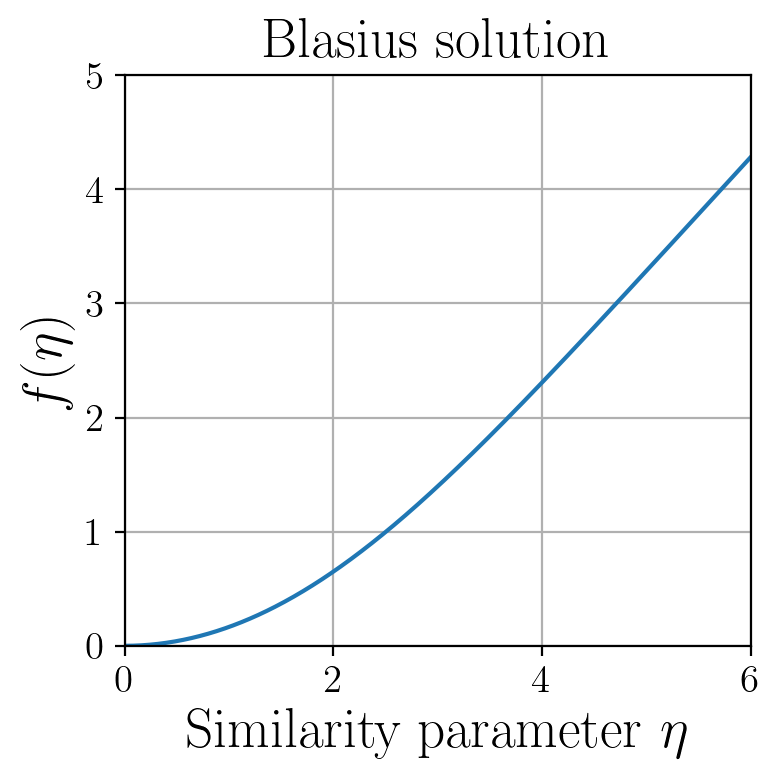

In [24]:
# Solve Blasius equations numerically

# Arbitrary "infinite" upper limit for domain
eta_inf = 200
# Step size
d_eta = 0.01
eta = np.arange(0, eta_inf, d_eta)

# Initial guess for unknown initial condition
F_init = [0, 0, 0]

# Solve root-finding problem for unknown initial condition
opt_res = root(bs.bc_fn, F_init, tol=1e-4)
F0 = [0, 0, opt_res.x[2]]

# Evaluate with resulting initial conditions
f = odeint(lambda y, t: bs.blasius_rhs(y), F0, eta)

pf.plot_blasius_solution(eta, f)

Then we can compare the inflow profile to the Blasius solution (dotted lines indicate region where the transitional balance begins, after $x \sim 150$.  Until that point there is a maximum deviation of about 6% from the Blasius solution.

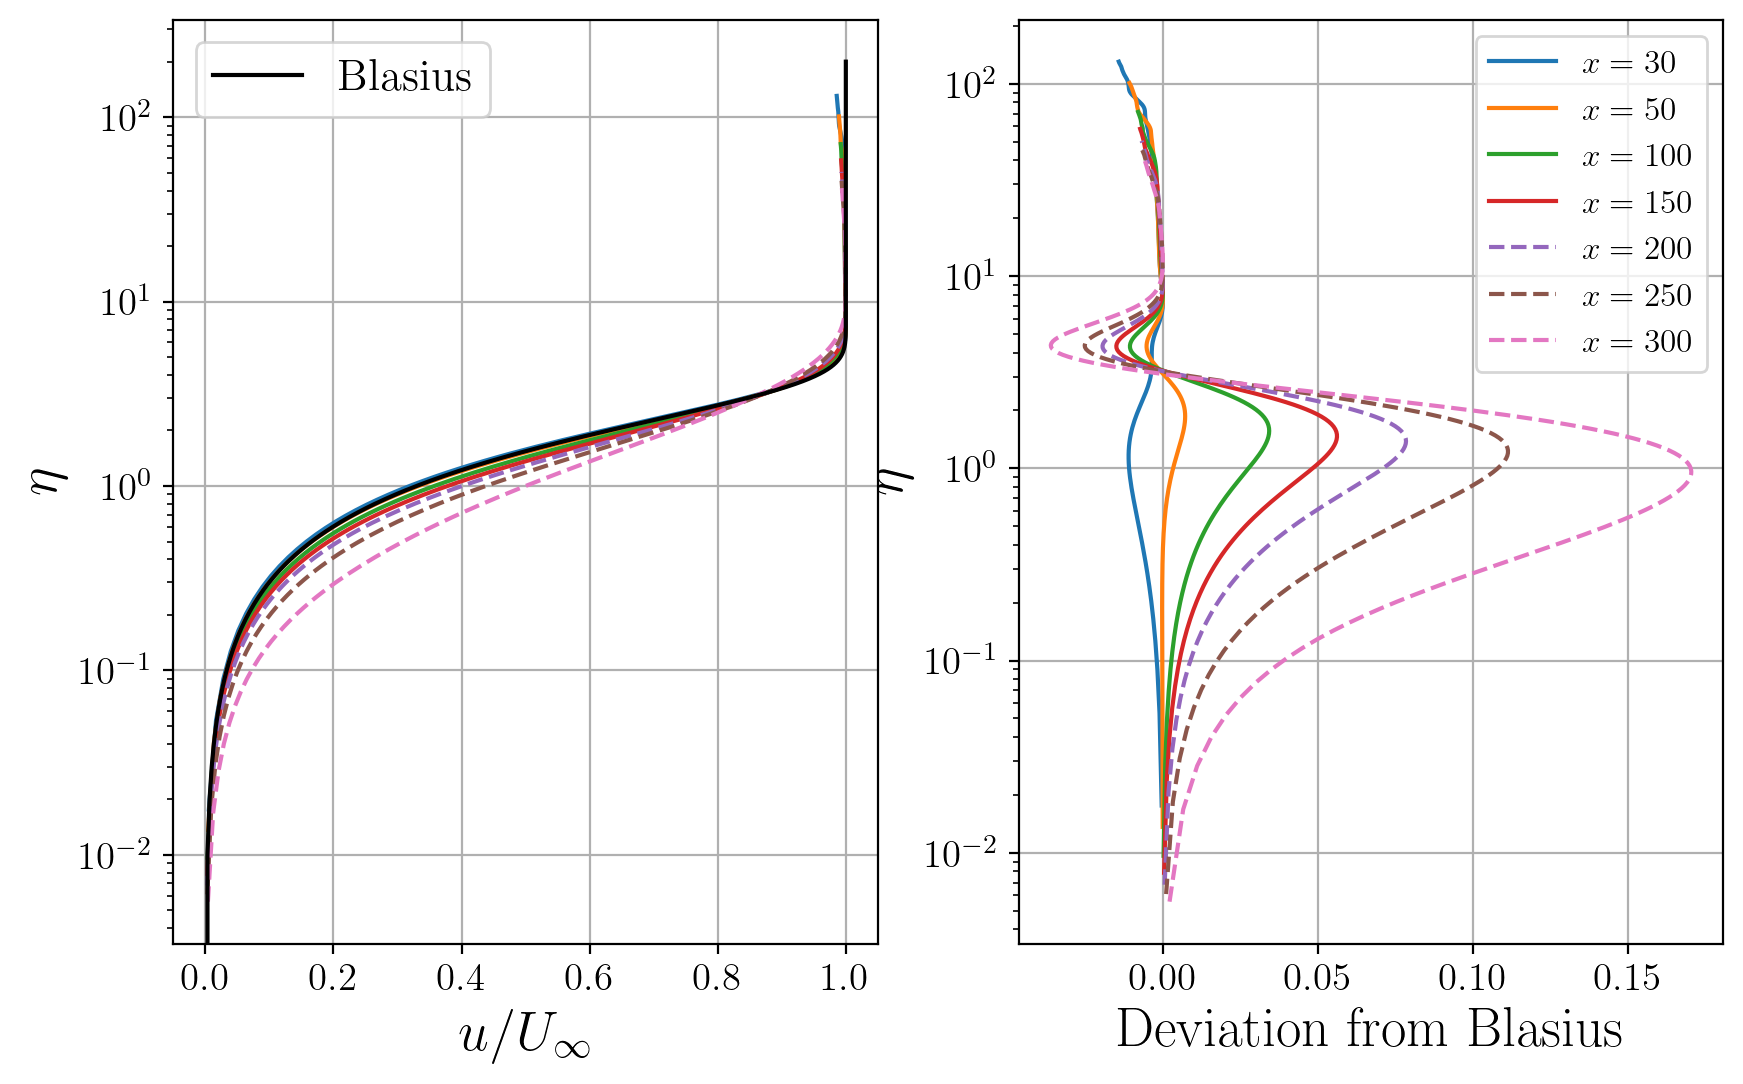

In [25]:
pf.plot_blasius_deviation(x, y, nx, ny, u, eta, f, U_inf, nu)